In [0]:
!git clone https://github.com/rslim087a/track

Cloning into 'track'...
remote: Enumerating objects: 12163, done.
remote: Total 12163 (delta 0), reused 0 (delta 0), pack-reused 12163
Receiving objects: 100% (12163/12163), 156.98 MiB | 14.22 MiB/s, done.
Checking out files: 100% (12160/12160), done.


In [0]:
!ls track

driving_log.csv  IMG


In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as npimg
import cv2
import pandas as pd
import ntpath
import random
from sklearn.utils import shuffle 
from sklearn.model_selection import train_test_split

In [0]:
datadir = 'track'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir,'driving_log.csv'), names= columns)
pd.set_option('display.max_colwidth', -1)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_382.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_382.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_670.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_670.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_724.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_724.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_792.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_792.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_860.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_860.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


In [0]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2018_07_16_17_11_43_382.jpg,left_2018_07_16_17_11_43_382.jpg,right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,center_2018_07_16_17_11_43_670.jpg,left_2018_07_16_17_11_43_670.jpg,right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,center_2018_07_16_17_11_43_724.jpg,left_2018_07_16_17_11_43_724.jpg,right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,center_2018_07_16_17_11_43_792.jpg,left_2018_07_16_17_11_43_792.jpg,right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,center_2018_07_16_17_11_43_860.jpg,left_2018_07_16_17_11_43_860.jpg,right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


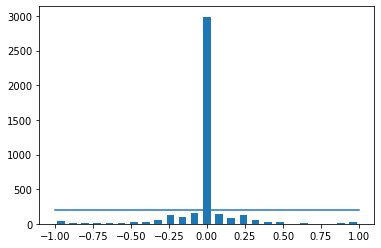

In [0]:
num_bins = 25
samples_per_bin = 200
hist,bins = np.histogram(data['steering'], num_bins)
center  = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center,hist,width=0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data 4053
removed 2790
remaining 1263


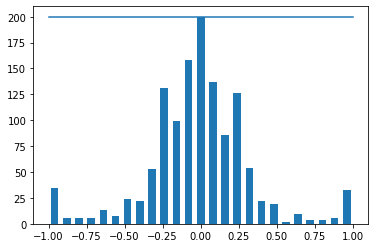

In [0]:
print('total data',len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i]>=bins[j] and data['steering'][i]<=bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
print('removed', len(remove_list))
data.drop(data.index[remove_list],inplace=True)
print('remaining', len(data))

hist, _ = np.histogram(data['steering'],num_bins)
plt.bar(center,hist,width=0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])), (samples_per_bin, samples_per_bin))


In [0]:
print(data.iloc[1])
def load_img_steering(datadir,df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center,left,right = indexed_data[0],indexed_data[1],indexed_data[2]
    image_path.append(os.path.join(datadir,center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG',data)

center      center_2018_07_16_17_11_44_137.jpg
left        left_2018_07_16_17_11_44_137.jpg  
right       right_2018_07_16_17_11_44_137.jpg 
steering    0                                 
throttle    0                                 
reverse     0                                 
speed       0.59835                           
Name: 8, dtype: object


In [0]:
X_train, X_valid, Y_train, Y_valid = train_test_split(image_paths,steerings,test_size=0.2,random_state=6)
print('training_samples: {}\nValid Samples: {}'.format(len(X_train),len(X_valid)))

training_samples: 1010
Valid Samples: 253


Text(0.5, 1.0, 'Validation Set')

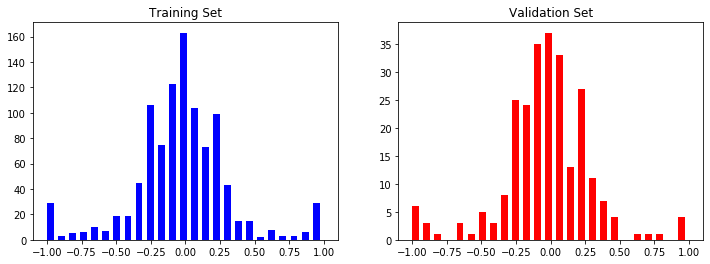

In [0]:
fig, axes = plt.subplots(1,2,figsize=(12,4))
axes[0].hist(Y_train,bins = num_bins, width=0.05,color='blue')
axes[0].set_title('Training Set')
axes[1].hist(Y_valid,bins = num_bins, width=0.05,color='red')
axes[1].set_title('Validation Set')


In [0]:
def img_preprocess(img):
  img = npimg.imread(img)
  img = img[60:135,:,:]
  img = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img,(3,3), 0)
  img = cv2.resize(img,(200,66))
  img=img/255.0
  return img

Text(0.5, 1, 'Processed')

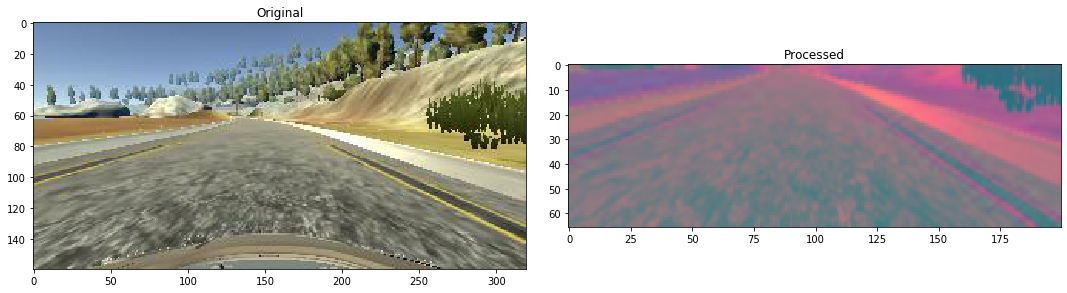

In [0]:
image = image_paths[100]
original_image = npimg.imread(image)
preprocesed_image = img_preprocess(image)

fig,axis = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axis[0].imshow(original_image)
axis[0].set_title('Original')
axis[1].imshow(preprocesed_image)
axis[1].set_title('Processed')

In [0]:
X_train=np.array(list(map(img_preprocess, X_train)))
X_valid=np.array(list(map(img_preprocess, X_valid)))

(1010, 66, 200, 3)


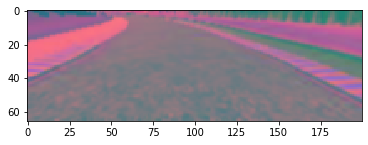

In [0]:
plt.imshow(X_train[random.randint(0,len(X_train)-1)])
print(X_train.shape)

**MODELO**

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten

print(tf.__version__)
print(tf.keras.__version__)

1.15.0
2.2.4-tf


In [0]:
def nvidia_model():
  model = Sequential()
  model.add(Conv2D(24,(5,5), strides=(2,2), input_shape=(66,200,3),activation='elu'))
  model.add(Conv2D(36,(5,5), strides=(2,2), activation='elu'))
  model.add(Conv2D(48,(5,5), strides=(2,2), activation='elu'))
  model.add(Conv2D(64,(3,3), activation='elu'))
  model.add(Conv2D(64,(3,3), activation='elu'))
 
  model.add(Dropout(0.5))

  model.add(Flatten())

  model.add(Dense(100,activation='elu'))
  model.add(Dropout(0.5))
  model.add(Dense(50,activation='elu'))
  model.add(Dropout(0.5))
  model.add(Dense(10,activation='elu'))
  model.add(Dropout(0.5))

  model.add(Dense(1))

  optimizer=Adam(lr=1e-3)
  model.compile(loss='mse',optimizer=optimizer)
  return model



In [0]:
model = nvidia_model()
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_9 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1152)             

In [0]:
history = model.fit(X_train, Y_train, epochs=30, validation_data=(X_valid, Y_valid),batch_size=100,verbose=1,shuffle=1)

Train on 1010 samples, validate on 253 samples
Epoch 1/30
1010/1010 [==============================] - 1s 967us/sample - loss: 0.4524 - val_loss: 0.0957
Epoch 2/30
1010/1010 [==============================] - 0s 375us/sample - loss: 0.2063 - val_loss: 0.0885
Epoch 3/30
1010/1010 [==============================] - 0s 344us/sample - loss: 0.1809 - val_loss: 0.0851
Epoch 4/30
1010/1010 [==============================] - 0s 339us/sample - loss: 0.1409 - val_loss: 0.0822
Epoch 5/30
1010/1010 [==============================] - 0s 337us/sample - loss: 0.1261 - val_loss: 0.0692
Epoch 6/30
1010/1010 [==============================] - 0s 332us/sample - loss: 0.1176 - val_loss: 0.0633
Epoch 7/30
1010/1010 [==============================] - 0s 337us/sample - loss: 0.1156 - val_loss: 0.0585
Epoch 8/30
1010/1010 [==============================] - 0s 325us/sample - loss: 0.1091 - val_loss: 0.0570
Epoch 9/30
1010/1010 [==============================] - 0s 325us/sample - loss: 0.0981 - val_loss: 0.0575

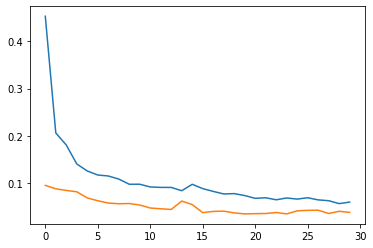

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [0]:
model.save('model.h5')

In [0]:
from google.colab import files
files.download('model.h5')